In [1]:
using Plots
using Distributions
using StatsBase
using JLD

In [39]:
gr()

Plots.GRBackend()

# Parameters

In [3]:
N_MAX_CARS = 20
A_MAX = 5
LAMBDA = [3, 4]
MU = [3, 2]
GAMMA = 0.9
R_A = -2
R_X = 10

10

# Load Optimal Policy and Value

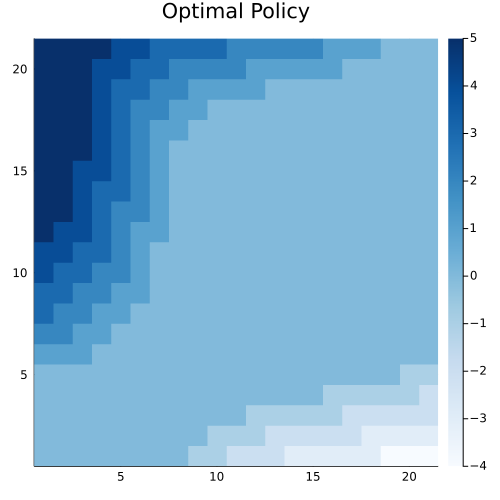

In [4]:
data = load("optimal.jld")

heatmap(data["policy"], title="Optimal Policy", size=(500, 500), c=cgrad(:Blues_9))

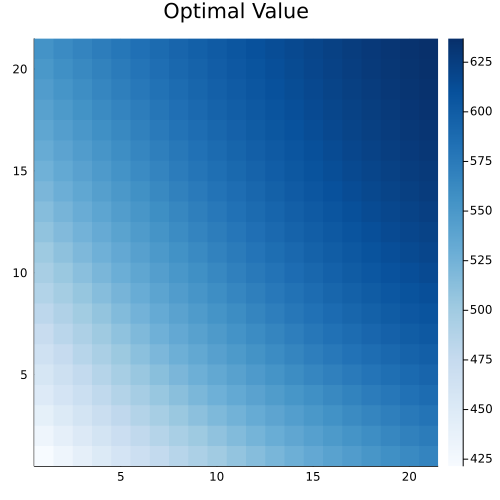

In [5]:
heatmap(data["value"], title="Optimal Value", size=(500, 500), c=cgrad(:Blues_9))

In [6]:
optimal_Policy = data["policy"]
optimal_Value = data["value"];

# Q-Learning

In [7]:
mutable struct State
    N1::Int64
    N2::Int64
end

Pre-calculated car rental and return numbers and their probabilities

In [8]:
f = Poisson(LAMBDA[1])
X1 = [i for i in 0:8*LAMBDA[1]]
pX1 = pdf(f, X1)

f = Poisson(LAMBDA[2])
X2 = [i for i in 0:8*LAMBDA[2]]
pX2 = pdf(f, X2)

f = Poisson(MU[1])
Y1 = [i for i in 0:8*MU[1]]
pY1 = pdf(f, Y1)

f = Poisson(MU[2])
Y2 = [i for i in 0:8*MU[2]]
pY2 = pdf(f, Y2)

17-element Array{Float64,1}:
 0.1353352832366127
 0.2706705664732254
 0.2706705664732254
 0.18044704431548364
 0.09022352215774178
 0.03608940886309671
 0.012029802954365572
 0.0034370865583901616
 0.0008592716395975415
 0.00019094925324389769
 3.81898506487796e-5
 6.9436092088690095e-6
 1.1572682014781686e-6
 1.7804126176587265e-7
 2.5434465966553194e-8
 3.391262128873753e-9
 4.2390776610922124e-10

Environment response function 

In [9]:
function Environment(S::State, A::Int64)
    """
    Evaluate new state and reward
    """
    new_S = State(S.N1 - A, S.N2 + A)
    
    x1 = min(sample(X1, Weights(pX1)), new_S.N1)
    x2 = min(sample(X2, Weights(pX2)), new_S.N2)

    reward = R_X*(x1 + x2) + abs(A)*R_A
    new_S.N1 -= x1
    new_S.N2 -= x2
    
    y1 = min(sample(Y1, Weights(pY1)), N_MAX_CARS - new_S.N1)
    y2 = min(sample(Y2, Weights(pY2)), N_MAX_CARS - new_S.N2)

    new_S.N1 += y1
    new_S.N2 += y2

    return (new_S, reward)
end

S = State(sample(0:N_MAX_CARS), sample(0:N_MAX_CARS))
println(S)
next_S, R = Environment(S, 3)
println(next_S)
println(R)

State(20, 15)
State(14, 13)
94


Randomly break ties

In [10]:
function amax_rand(arr::Array{Float64, 1})
    sample(findall(x->x==maximum(arr), arr))
end

amax_rand([1., 5.1, 3., 4., 5.2])

5

Action Space and index to action mappings

In [11]:
A_to_idx = Dict()
idx_to_A = Dict()

for a in -A_MAX:A_MAX
    idx = a + A_MAX + 1
    A_to_idx[a] = idx
    idx_to_A[idx] = a
end   

Action_space = collect(-A_MAX:A_MAX)
println(Action_space)

[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]


In [12]:
function epsilon_greedy_update(S::State, A::Int64, epsilon::Float64)  
    low_A = -minimum([A_MAX, S.N2, N_MAX_CARS - S.N1])
    high_A = minimum([A_MAX, S.N1, N_MAX_CARS - S.N2])
    p = epsilon/(high_A - low_A + 1)
            
    probs = zeros(2*A_MAX + 1)
    
    for a in low_A:high_A
        probs[A_to_idx[a]] = p
    end
    
    A_max_idx = A_to_idx[A]
    probs[A_max_idx] += 1 - epsilon
        
    return probs
end

epsilon_greedy_update (generic function with 1 method)

In [13]:
function get_greedy(S::State, Q::Array{Float64, 3})
    low_A = -minimum([A_MAX, S.N2, N_MAX_CARS - S.N1])
    high_A = minimum([A_MAX, S.N1, N_MAX_CARS - S.N2])
    
    return idx_to_A[amax_rand([Q[S.N1 - A + 1, S.N2 + A + 1, A_to_idx[A]] 
                for A in low_A:high_A]) + A_to_idx[low_A] - 1]
end


function initialise_everything(epsilon::Float64=0.1)
    bhv_Policy = zeros(Float64, N_MAX_CARS + 1, N_MAX_CARS + 1, 2*A_MAX + 1)
    
    Q1 = zeros(N_MAX_CARS + 1, N_MAX_CARS + 1, 2*A_MAX + 1)
    Q2 = zeros(N_MAX_CARS + 1, N_MAX_CARS + 1, 2*A_MAX + 1)

    # For each afterstate, update all relevatent state argmaxes
    Q = Q1 + Q2
    for N1 in 0:N_MAX_CARS, N2 in 0:N_MAX_CARS
        S = State(N1, N2)
                
        A = get_greedy(S, Q)
        
        bhv_Policy[N1 + 1, N2 + 1, :] = epsilon_greedy_update(S, A, epsilon)
    end
    
    return Q1, Q2, bhv_Policy
end

Q1, Q2, bhv_Policy = initialise_everything();

## Main loop

In [14]:
function metrics(opt_policy, tgt_policy, mae, mse)
    r = abs.(opt_policy - tgt_policy)
    
    append!(mae, mean(r))
    append!(mse, sqrt(mean(r.^2)))
end

metrics (generic function with 1 method)

In [15]:
Q_MSE = []
Q_MAE = []

Q, _, bhv_Policy = initialise_everything()

MAX_STEPS = 250000000
epsilon = 0.1
Q_log_steps = []
log_period = 100

# Alpha scheduler
ALPHA = 0.5
decay = 1
period = convert(Int64, round(MAX_STEPS/512))

488281

In [16]:
@time for st in 1:MAX_STEPS
    S = State(sample(0:N_MAX_CARS), sample(0:N_MAX_CARS))
    
    A = sample(Action_space, Weights(bhv_Policy[S.N1 + 1, S.N2 + 1, :]))
    
    next_S, R = Environment(S, A)    

    next_A = get_greedy(next_S, Q)
        
    A_idx = A_to_idx[A]
    next_A_idx = A_to_idx[next_A]

    G = R + GAMMA*Q[next_S.N1 - next_A + 1, next_S.N2 + next_A + 1, next_A_idx]

    Q[S.N1 - A + 1, S.N2 + A + 1, A_idx] += ALPHA*(G - Q[S.N1 - A + 1, S.N2 + A + 1, A_idx])

    A_star = get_greedy(S, Q)
    bhv_Policy[S.N1 + 1, S.N2 + 1, :] = epsilon_greedy_update(S, A_star, epsilon)
    
    # Evaluate metrics and log performance
    if st % log_period == 1
        tgt_Policy = [get_greedy(State(N1, N2), Q) for N1 in 0:N_MAX_CARS, N2 in 0:N_MAX_CARS]
        metrics(tgt_Policy, optimal_Policy, Q_MAE, Q_MSE)
        log_period = floor(Int64, log_period*1.05)
        append!(Q_log_steps, st)
    end
    
    if st % period == 0
        ALPHA *= min(decay/(decay + 4), 0.5)
        ALPHA = maximum([ALPHA, 0.0001])
        decay += 1
        period *= 2
    end
end

3814.966554 seconds (22.21 G allocations: 829.106 GiB, 3.98% gc time)


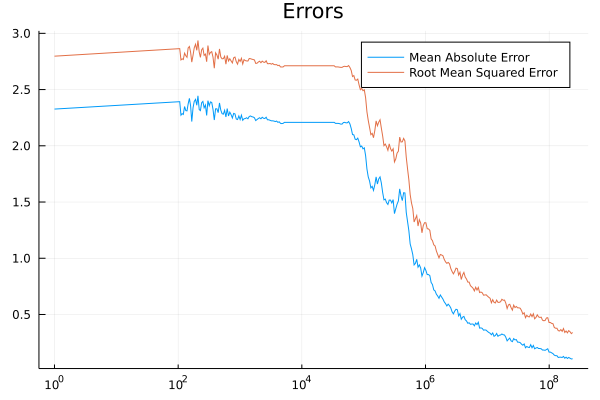

In [48]:
plot(Q_log_steps, Q_MAE, label="Mean Absolute Error", xaxis=:log, title="Errors")
plot!(Q_log_steps, Q_MSE, label="Root Mean Squared Error", xaxis=:log)

In [49]:
png("Error.png")

In [22]:
Q_MAE[end]

0.10657596371882086

In [23]:
Q_MSE[end]

0.3400680204068024

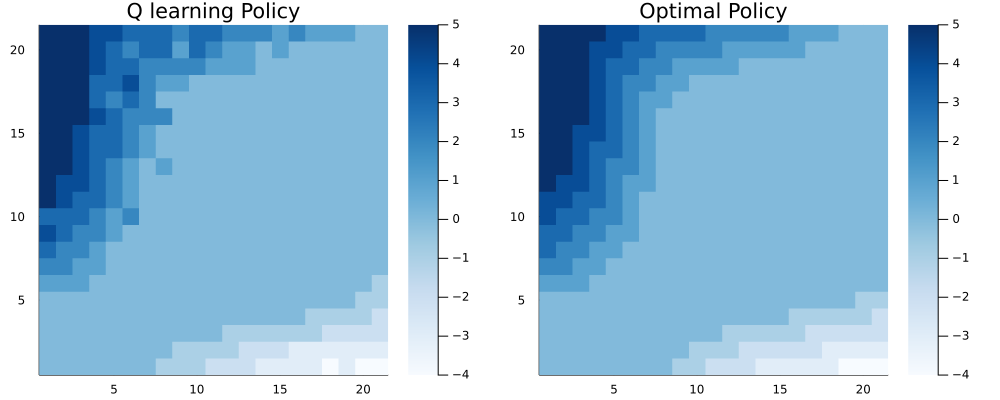

In [46]:
tgt_Policy = [get_greedy(State(N1, N2), Q) for N1 in 0:N_MAX_CARS, N2 in 0:N_MAX_CARS]

l = @layout [a b]

p1 = heatmap(tgt_Policy, title="Q learning Policy", size=(1000, 400), c=cgrad(:Blues_9))
p2 = heatmap(optimal_Policy, title="Optimal Policy", size=(1000, 400), c=cgrad(:Blues_9))

plot(p1, p2, layout=l)

In [47]:
png("Policy.png")

In [25]:
tgt_Value = zeros(N_MAX_CARS+1, N_MAX_CARS+1)

for N1 in 0:N_MAX_CARS, N2 in 0:N_MAX_CARS
    A = get_greedy(State(N1, N2), Q)
    tgt_Value[N1 + 1, N2 + 1] = Q[N1 - A + 1, N2 + A + 1, A_to_idx[A]]
end 

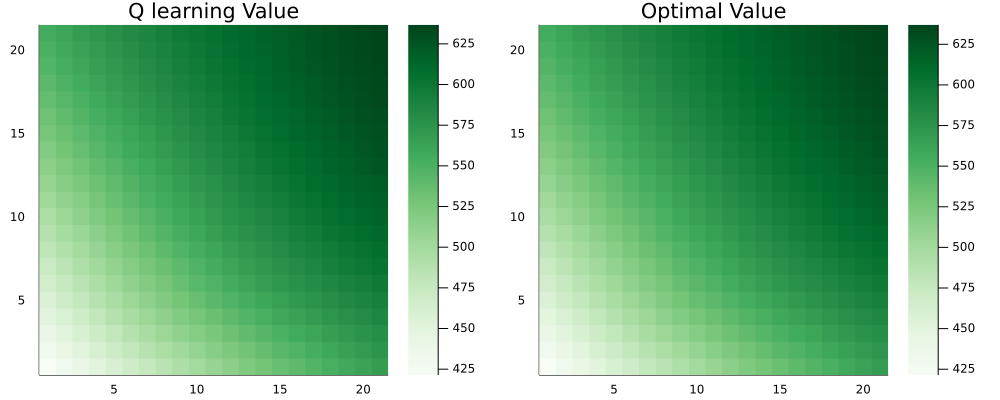

In [44]:
l = @layout [a b]

p1 = heatmap(tgt_Value, title="Q learning Value", size=(1000, 400), c=cgrad(:Greens_9))
p2 = heatmap(optimal_Value, title="Optimal Value", size=(1000, 400), c=cgrad(:Greens_9))

plot(p1, p2, layout=l)

In [45]:
png("Value.png")

In [28]:
maximum(abs.(1 .- tgt_Value./optimal_Value))

0.0010753793118244426